In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
'''
   This notebook provides a pipeline
   for skin allergies classification
   using ensemble CNN technique
'''

# Ownership
__author__ = ["M. Haseeb Hassan"]
__copyright__ = ["Copyrights @ hacceebhassan"]
__license__ = "MIT"
__version__ = "1.0.1"
__maintainer__ = "M. Haseeb Hassan"
__email__ = "hacceebhassan@gmail.com"
__status__ = "Development"


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
###---------- Importing Libraries ----------###
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical 
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

sns.set(color_codes = True)

#Global Variables
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']


### **Pre-Processing**

We start with creating a dictionary to map ImageId and ImagePath which will be used into add images to the master dataframe HAM10000_metadata.csv.

In [6]:
# Create a dictionary with image_id, image_path as key value pairs. 
base_skin_dir = os.getcwd()

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir,'*','*','*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on
lesion_type_dict = {
                    'nv': 'Melanocytic nevi',
                    'mel': 'Melanoma',
                    'bkl': 'Benign keratosis-like lesions ',
                    'bcc': 'Basal cell carcinoma',
                    'akiec': 'Actinic keratoses',
                    'vasc': 'Vascular lesions',
                    'df': 'Dermatofibroma'
                    }

In [9]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'data/HAM10000_metadata.csv'))

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/My Drive/Colab Notebooks/ensemb...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/My Drive/Colab Notebooks/ensemb...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/My Drive/Colab Notebooks/ensemb...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/My Drive/Colab Notebooks/ensemb...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/My Drive/Colab Notebooks/ensemb...,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,/content/drive/My Drive/Colab Notebooks/ensemb...,Actinic keratoses,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,/content/drive/My Drive/Colab Notebooks/ensemb...,Actinic keratoses,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,/content/drive/My Drive/Colab Notebooks/ensemb...,Actinic keratoses,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,/content/drive/My Drive/Colab Notebooks/ensemb...,Actinic keratoses,0


In [10]:
# Check Null Values
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [11]:
# Fill Null Values
skin_df["age"].fillna(skin_df.age.median(), inplace = True)
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [12]:
# Loading Images to dataframe
%%time
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

CPU times: user 1min 47s, sys: 2.63 s, total: 1min 50s
Wall time: 2min 2s


In [13]:
# Checking the dataframe
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/My Drive/Colab Notebooks/ensemb...,Benign keratosis-like lesions,2,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/My Drive/Colab Notebooks/ensemb...,Benign keratosis-like lesions,2,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/My Drive/Colab Notebooks/ensemb...,Benign keratosis-like lesions,2,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/My Drive/Colab Notebooks/ensemb...,Benign keratosis-like lesions,2,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/My Drive/Colab Notebooks/ensemb...,Benign keratosis-like lesions,2,"[[[134, 90, 113], [147, 102, 125], [159, 115, ..."


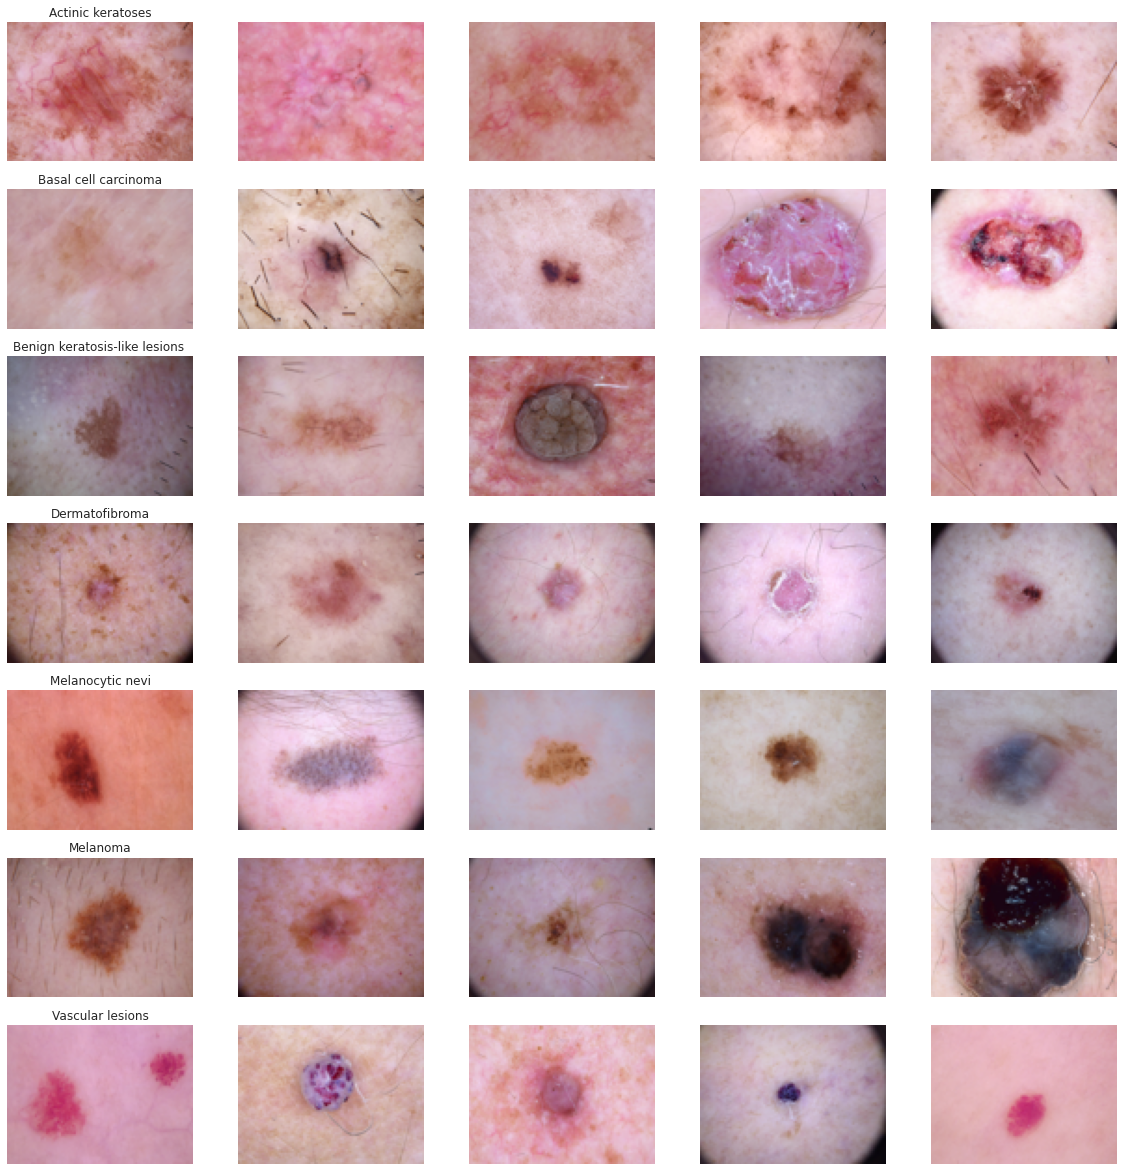

In [14]:
# Seeing the sample images of all classes
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
# fig.savefig('category_samples.png', dpi=300)

### **Data Preparation for Model**

In [15]:
# Splitting into training and test sets
features = skin_df["image"]
target = skin_df["cell_type_idx"]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.1, random_state = 999)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.165, random_state = 999)
print("Shape of entire dataset: {}".format(str(features.shape)))
print("Shape of train data: {}".format(str(X_train.shape)))
print("Shape of test data: {}".format(str(X_test.shape)))
print("Shape of val data: {}".format(str(X_val.shape)))

Shape of entire dataset: (10015,)
Shape of train data: (7525,)
Shape of test data: (1002,)
Shape of val data: (1488,)


In [16]:
# Saving Categorical data to use it later
y_test_enc = y_test

In [17]:
# Getting parameters for normalization of the data
l = ["train","val","test"]
#l = ["train","test"]

for x in l:
    globals()["X_{}".format(x)] = np.asarray(globals()["X_{}".format(x)].tolist())
    globals()["X_{}_mean".format(x)] = np.mean(globals()["X_{}".format(x)])
    globals()["X_{}_std".format(x)] = np.std(globals()["X_{}".format(x)])
    globals()["X_{}".format(x)] = (globals()["X_{}".format(x)]-globals()["X_{}_mean".format(x)])/globals()["X_{}_std".format(x)]

In [18]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)
y_val = to_categorical(y_val, num_classes = 7)

# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
X_train = X_train.reshape(X_train.shape[0], *(75, 100, 3))
X_test = X_test.reshape(X_test.shape[0], *(75, 100, 3))
X_val = X_val.reshape(X_val.shape[0], *(75, 100, 3))

### **Standalone CNN**

In [27]:
# Data Augmentation

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [35]:
input_shape = (75, 100, 3)
num_classes = 7

# define model
standalone = Sequential()
standalone.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu', input_shape = input_shape))
standalone.add(MaxPool2D(pool_size = (2,2)))
standalone.add(Flatten())
standalone.add(Dense(num_classes, activation = 'softmax'))
standalone.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:
epochs = 20
batch_size = 50

# fitting the model
performance = standalone.fit(datagen.flow(X_train,y_train, batch_size=batch_size), 
                             epochs = epochs, 
                             steps_per_epoch = X_train.shape[0]//batch_size, 
                             validation_data = (X_val,y_val),
                             verbose=0)

In [37]:
# evaluate the model
_, train_acc = standalone.evaluate(X_train, y_train, verbose=0)
_, test_acc = standalone.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.777, Test: 0.734


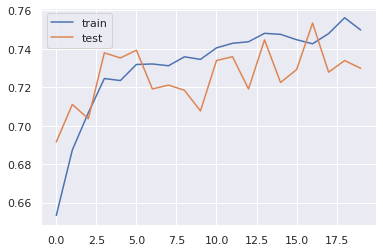

In [41]:
# learning curves of model accuracy
plt.plot(performance.history['accuracy'], label='train')
plt.plot(performance.history['val_accuracy'], label='test')
plt.legend()
plt.show()

### **Ensemble Of Convolutional Neural Networks**

In [23]:
# Define 5 CNN models

from keras.optimizers import RMSprop, Adam
from keras.layers import DepthwiseConv2D, Reshape, Activation

nets = 3
model = [0] *nets
input_shape = (75, 100, 3)
num_classes = 7

for j in range(nets):
    model[j] = Sequential()
    #First Layer
    model[j].add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu',input_shape = input_shape))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu',input_shape = input_shape))
    model[j].add(BatchNormalization())
    model[j].add(MaxPool2D(pool_size = (2,2)))

    #Second Layer
    model[j].add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu',input_shape = input_shape))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu',input_shape = input_shape))
    model[j].add(BatchNormalization())
    model[j].add(MaxPool2D(pool_size = (2,2)))

    #Third layer
    model[j].add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu',input_shape = input_shape))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu',input_shape = input_shape))
    model[j].add(BatchNormalization())
    model[j].add(MaxPool2D(pool_size = (2,2)))

    #Output layer
    model[j].add(Flatten())
    model[j].add(Dense(512, activation = 'relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dense(num_classes,activation = 'softmax'))

    # Compile each model
    model[j].compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])

    
print('All Models Defined')

All Models Defined


In [24]:
#LR Reduction Callback
from keras.callbacks import ReduceLROnPlateau
#learning_rate_reduction=ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=0, factor=0.5, min_lr=0.00001)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [25]:
# Train for 20 epochs
history = [0] * nets
epochs = 20
batch_size = 50

for j in range(nets):
    print(f'Individual Net : {j+1}')   
    history[j] = model[j].fit(datagen.flow(X_train,y_train, batch_size=batch_size), 
                              epochs = epochs, 
                              steps_per_epoch = X_train.shape[0]//batch_size, 
                              validation_data = (X_val,y_val), 
                              callbacks=[learning_rate_reduction], verbose=0)
    print('')

    print("CNN Model {0:d}: Epochs={1:d}, Training accuracy={2:.5f}, Validation accuracy={3:.5f}".format(j+1,epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))
    print('--------------------------------------------------')


Individual Net : 1

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

CNN Model 1: Epochs=20, Training accuracy=0.87572, Validation accuracy=0.78831
--------------------------------------------------
Individual Net : 2

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

CNN Model 2: Epochs=20, Training accuracy=0.87853, Validation accuracy=0.78159
--------------------------------------------------
Individual Net : 3

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

CNN Model 3: Epochs=20, Training

126

### **Testing**

In [26]:
# Testing
for t in range(nets):
  print(f'Individual Net : {t+1}')
  loss, accuracy = model[t].evaluate(X_test, y_test, verbose=1)
  loss_v, accuracy_v = model[t].evaluate(X_val, y_val, verbose=1)
  print('')
  print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
  print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
  print('--------------------------------------------------')

Individual Net : 1
47/47 [==============================] - 1s 17ms/step - loss: 0.6712 - accuracy: 0.7782

Validation: accuracy = 0.778226  ;  loss_v = 0.671155
Test: accuracy = 0.806387  ;  loss = 0.589304
--------------------------------------------------
Individual Net : 2
47/47 [==============================] - 1s 17ms/step - loss: 0.6553 - accuracy: 0.7776

Validation: accuracy = 0.777554  ;  loss_v = 0.655293
Test: accuracy = 0.789421  ;  loss = 0.631972
--------------------------------------------------
Individual Net : 3
47/47 [==============================] - 1s 17ms/step - loss: 0.6572 - accuracy: 0.7796

Validation: accuracy = 0.779570  ;  loss_v = 0.657161
Test: accuracy = 0.800399  ;  loss = 0.581529
--------------------------------------------------


### **Soft Voting Ensemble**

In [42]:
# Making predictions
yhats = [mod.predict(X_test) for mod in model]
yhats = np.array(yhats)
# sum across ensemble members
summed = np.sum(yhats, axis=0)
# argmax across classes
result = np.argmax(summed, axis=1)

### **Model Averaging Ensemble**

In [43]:
# make an ensemble prediction for multi-class classification

def ensemble_predictions(members, testX):
	# make predictions
	yhats = [model.predict(testX) for model in members]
	yhats = np.array(yhats)
	# sum across ensemble members
	summed = np.sum(yhats, axis=0)
	# argmax across classes
	result = np.argmax(summed, axis=1)
	return result


In [44]:
# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
	# select a subset of members
	subset = members[:n_members]
	# make prediction
	yhat = ensemble_predictions(subset, testX)
	# calculate accuracy
	return accuracy_score(testy, yhat)

In [50]:
# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()
for i in range(1, len(history)+1):
	# evaluate model with i members
	ensemble_score = evaluate_n_members(model, i, X_test, y_test_enc)
	# evaluate the i'th model standalone
	testy_enc = to_categorical(y_test)
	_, single_score = model[i-1].evaluate(X_test, y_test, verbose=0)
	# summarize this step
	print(f'> Individual Net {i} = %.3f, Ensemble=%.3f' % (single_score, ensemble_score))
	ensemble_scores.append(ensemble_score)
	single_scores.append(single_score)
 

# summarize average accuracy of a single final model
print('')
print('------------------------------')
print('Avg. Accuracy = %.3f (%.3f)' % (np.mean(single_scores), np.std(single_scores)))


> Individual Net 1 = 0.806, Ensemble=0.806
> Individual Net 2 = 0.789, Ensemble=0.815
> Individual Net 3 = 0.800, Ensemble=0.811

------------------------------
Avg. Accuracy = 0.799 (0.007)


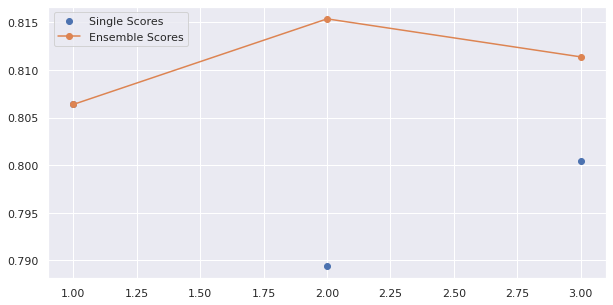

In [51]:
# plot score vs number of ensemble members
plt.figure(figsize=[10, 5])
x_axis = [i for i in range(1, len(model)+1)]
plt.plot(x_axis, single_scores, marker='o', linestyle='None')
plt.plot(x_axis, ensemble_scores, marker='o')
labels = ['Single Scores', 'Ensemble Scores']
plt.legend(labels)
plt.show()

### **Weight Averaging Ensemble**

In [52]:
# calculated a weighted sum of predictions
def weighted_sum(weights, yhats):
	rows = list()
	for j in range(yhats.shape[1]):
		# enumerate values
		row = list()
		for k in range(yhats.shape[2]):
			# enumerate members
			value = 0.0
			for i in range(yhats.shape[0]):
				value += weights[i] * yhats[i,j,k]
			row.append(value)
		rows.append(row)
	return array(rows)

In [53]:
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, weights, testX):
	# make predictions
	yhats = [model.predict(testX) for model in members]
	yhats = np.array(yhats)
	# weighted sum across ensemble members
	summed = np.tensordot(yhats, weights, axes=((0),(0)))
	# argmax across classes
	result = np.argmax(summed, axis=1)
	return result

In [54]:
# evaluate a specific number of members in an ensemble
def evaluate_ensemble(members, weights, testX, testy):
	# make prediction
	yhat = ensemble_predictions(members, weights, testX)
	# calculate accuracy
	return accuracy_score(testy, yhat)

In [55]:
# evaluate each single model on the test set
n_members = nets
members = model
for i in range(n_members):
	_, test_acc = members[i].evaluate(X_test, y_test, verbose=0)
	print('Model %d: %.3f' % (i+1, test_acc))

Model 1: 0.806
Model 2: 0.789
Model 3: 0.800


In [56]:
# evaluate averaging ensemble (equal weights)
weights = [1.0/n_members for _ in range(n_members)]
score = evaluate_ensemble(members, weights, X_test, y_test_enc)
print('Equal Weights Score: %.3f' % score)

Equal Weights Score: 0.811


In [57]:
# normalize a vector to have unit norm
def normalize(weights):
	# calculate l1 vector norm
	result = np.linalg.norm(weights, 1)
	# check for a vector of all zeros
	if result == 0.0:
		return weights
	# return normalized vector (unit norm)
	return weights / result

In [60]:
# grid search weights
def grid_search(members, testX, testy):
	# define weights to consider
	w = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	best_score, best_weights = 0.0, None
	# iterate all possible combinations (cartesian product)
	for weights in itertools.product(w, repeat=len(members)):
		# skip if all weights are equal
		if len(set(weights)) == 1:
			continue
		# hack, normalize weight vector
		weights = normalize(weights)
		# evaluate weights
		score = evaluate_ensemble(members, weights, testX, testy)
		if score > best_score:
			best_score, best_weights = score, weights
			print('Best Weights : %s, Accuracy :  %.3f' % (best_weights, best_score))
	return list(best_weights)

In [ ]:
# grid search weights
weights = grid_search(members, X_test, y_test_enc)
score = evaluate_ensemble(members, weights, X_test, y_test)
print('Grid Search Weights: %s, Score: %.3f' % (weights, score))

Best Weights : [0. 0. 1.], Accuracy :  0.800
